------------------
Nome: Izabela Hammerschlag

Data: 13/03/24

------------------

# Sweet Lift Taxi - Projeto proposto pela Tripleten

----------------------------
# Contents 

* Descrição do Projeto
* Visão geral
* Análise
* Treinamento
* Testando
* Conclusão

# Descrição do Projeto  

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto 

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados 

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

# Visão geral

Importando as Bibliotecas necessárias para execução do projeto:

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool


Lendo o dataframe:

In [54]:
df = pd.read_csv('./taxi.csv')

Visualizando as primeiras 5 linhas de df:

In [55]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


O arquivo tem uma coluna com dados data e hora e outra coluna com número de pedidos de taxi a cada hora.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [57]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Nas informações do dataframe podemos concluir que não tem dados ausentes e o tipo de dado da coluna datetime precisa ser corrigido para Dtype correto (de object para datetime).

In [58]:
df.duplicated().sum()

0

Também não há valores duplicados. Com isso, podemos seguir para checagem das colunas.

Coluna `'num_orders'`:

<AxesSubplot: >

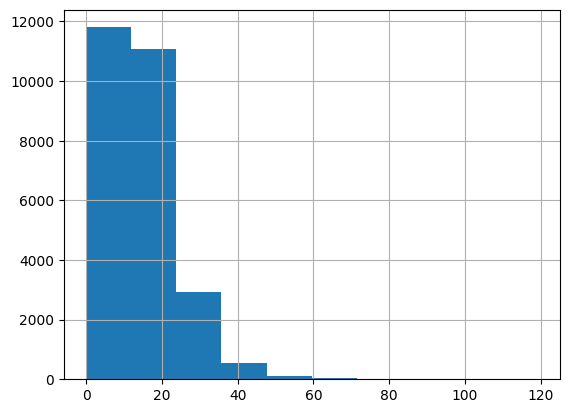

In [59]:
df['num_orders'].hist() # valores mais frequentes entre 0 e 20

In [60]:
df['num_orders'].describe() # podemos observar valores max, min, media, mediana, desvio padrão e quartis

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Observando os dados da coluna `'num_orders'` Os valores estão prontos para análise.

Coluna `'datetime'`:

In [61]:
df['datetime'] 

0        2018-03-01 00:00:00
1        2018-03-01 00:10:00
2        2018-03-01 00:20:00
3        2018-03-01 00:30:00
4        2018-03-01 00:40:00
                ...         
26491    2018-08-31 23:10:00
26492    2018-08-31 23:20:00
26493    2018-08-31 23:30:00
26494    2018-08-31 23:40:00
26495    2018-08-31 23:50:00
Name: datetime, Length: 26496, dtype: object

Os dados desta coluna são gerados a cada 10 min, entre `2018-03-01 00:00:00 e 2018-08-31 23:50:00`

Corrigido o dtype da coluna `datetime`:

In [62]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [63]:
df.info() # corrigido Dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [64]:
df['datetime'].head()

0   2018-03-01 00:00:00
1   2018-03-01 00:10:00
2   2018-03-01 00:20:00
3   2018-03-01 00:30:00
4   2018-03-01 00:40:00
Name: datetime, dtype: datetime64[ns]

In [65]:
df.index.is_monotonic # indica que os dados subjacentes do objeto Index fornecido estão aumentando monotonicamente.

/var/folders/0g/77xcjvfx6374w8nl9cs4542h0000gp/T/ipykernel_2836/3588646876.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic # indica que os dados subjacentes do objeto Index fornecido estão aumentando monotonicamente.


True

Os dados estão corrigidos e prontos para análise.

# Análise 

In [66]:
df = df.set_index('datetime') 

In [67]:
df # a coluna datetime agora é o índice

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


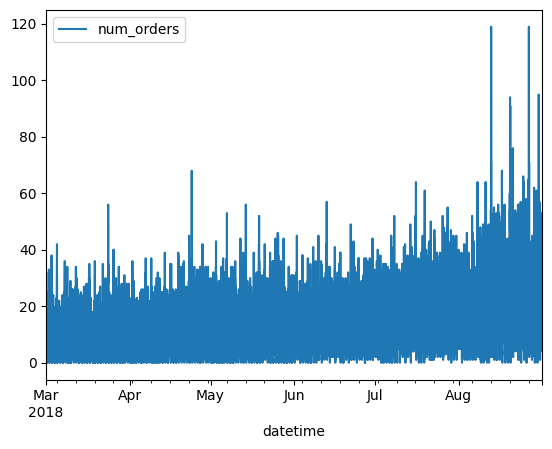

In [68]:
df.plot(); # distribuição do num_orders ao longo do tempo (datetime)

De acordo com o plot podemos visualizar um crescimento no número de pedidos de taxis de forma leve e gradual ao longo do tempo, além de alguns "outliers" em tempos curtos. Estes podem estar associados aos finais de semana. Mas precisamos estudar os dados com mais detalhes para afirmar isso.

In [69]:
df.index.min() # data-hora inicial

Timestamp('2018-03-01 00:00:00')

In [70]:
df.index.max() # data-hora final

Timestamp('2018-08-31 23:50:00')

Para visualizar melhor os dados, vamos pegar uma fatia. Por exemplo, de abril a maio:

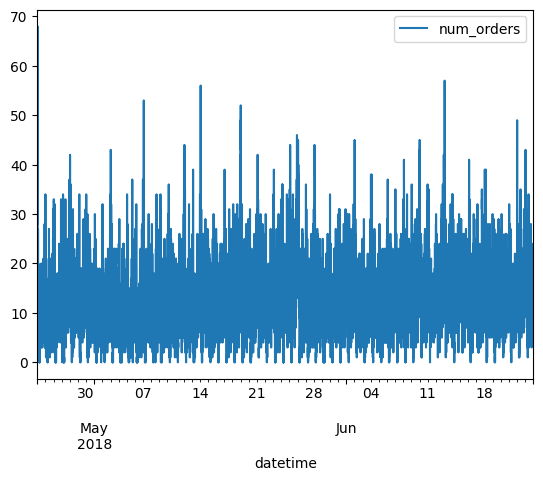

In [71]:
df[(df.index >= '2018-04-24') & (df.index <= '2018-06-24')].plot();

Outro exemplo, de junho a agosto:

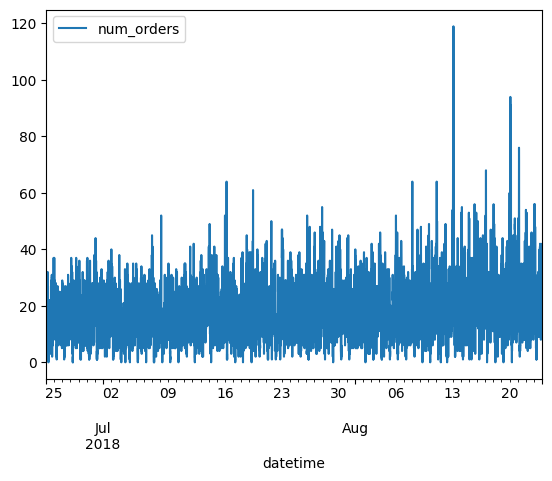

In [72]:
df[(df.index >= '2018-06-24') & (df.index <= '2018-08-24')].plot();

Mesmo com este "Zoom" comparado ao primeiro plot, não conseguimos visualizar mais detalhes ou qualquer conclusão/teoria para analisar. Por isso, vamos fazer um redimensionamento dos dados (agrupando) de hora em hora ao invés de a cada 10 minutos:

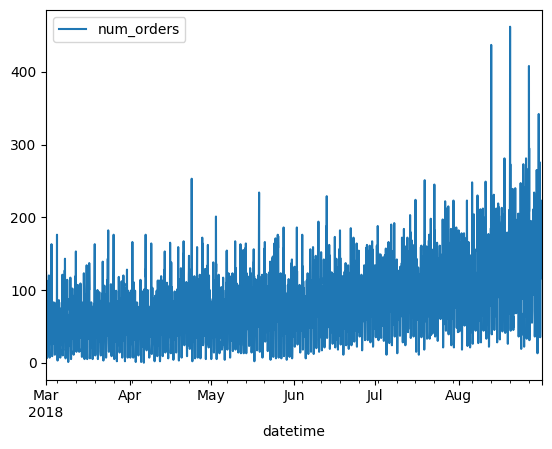

In [73]:
df.resample('1H').sum().plot(); # agrupando por hora (somando num_order de cada hora neste agrupamento)

No plot acima é possível visualizar melhor o leve crescimento gradual do número de pedidos de taxi.

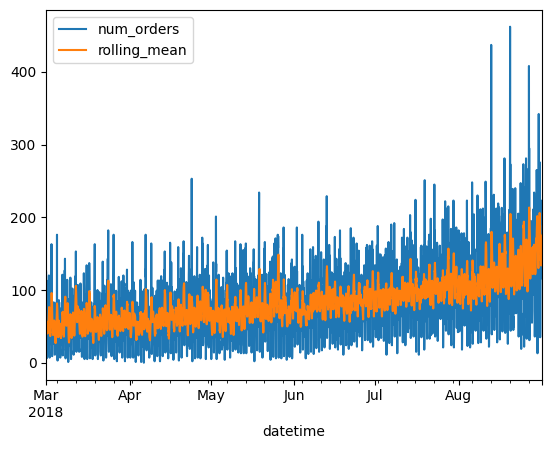

In [74]:
df1= df.resample('1H').sum()
df1['rolling_mean'] = df1.rolling(10).mean()
df1.plot(); # plot da média movel

No plot acima é possível visualizar a média movel comparada ao plot anterior.  
A média móvel pode ser utilizada aqui como um indicador, ela suaviza os dados do num_orders ao longo do tempo (com a média tomado de 10 em 10, sempre excluindo o último e pegando o próximo para o novo cálculo da média) e forma um indicador que segue uma tendencia de crescimento.

Quais horários são os horários de pico (maior número de chamadas de taxi)?

In [75]:
df2 = df.resample('1H').sum().copy().reset_index() # voltamos ao df com datetime na coluna
df2['date'] = df2['datetime'].dt.date # criando uma coluna chamada date
idx = df2.groupby('date')['num_orders'].idxmax() # agrupando por date e guardando em idx os indices com maiores valores de num_orders
result = df2.loc[idx, ['date', 'datetime', 'num_orders']] # localizando esses indices na tabela
result['hour'] = result.datetime.dt.hour # criando coluna hour em result
result['hour'].value_counts() # horários com maiores números de pedidos

0     77
23    20
16    17
2     16
22    13
1     11
3     10
4      5
17     5
21     4
10     3
18     2
20     1
Name: hour, dtype: int64

Aparentemente o horário que tem mais pedidos de taxi são em primeiro lugar: 00:00-00:59h, seguido de 23:00-00:59h em segundo lugar, 16:00h-16:59h em terceiro lugar, 02:00h-02:59h em quarto lugar e 22:00h-22:59h em quinto.

In [76]:
df = df.reset_index()
df.groupby(df['datetime'].dt.hour)['num_orders'].mean()
# Outra maneira de visualizar os hórarios com maiores pedidos de taxi

datetime
0     24.067029
1     17.394022
2     18.845109
3     17.003623
4     14.484601
5      7.105072
6      4.195652
7      4.878623
8     12.174819
9     14.805254
10    15.519928
11    13.748188
12    11.271739
13    11.862319
14    12.527174
15    14.657609
16    19.024457
17    15.453804
18    11.559783
19    12.889493
20    13.643116
21    15.868659
22    16.416667
23    18.294384
Name: num_orders, dtype: float64

In [77]:
df = df.set_index('datetime')
#df.between_time("01:00","23:00")
df.at_time('00:00')

,num_orders
datetime,
2018-03-01,9
2018-03-02,11
2018-03-03,14
2018-03-04,12
2018-03-05,17
...,...
2018-08-27,61
2018-08-28,39
2018-08-29,37


Horário de pico é meia noite

Abaixo vamos visualizar os dados decompostos em tendencia, sazonalidade e resíduos:

In [78]:
decomposed = seasonal_decompose(df.resample("1D").sum()) # reamostrando com 1 dia

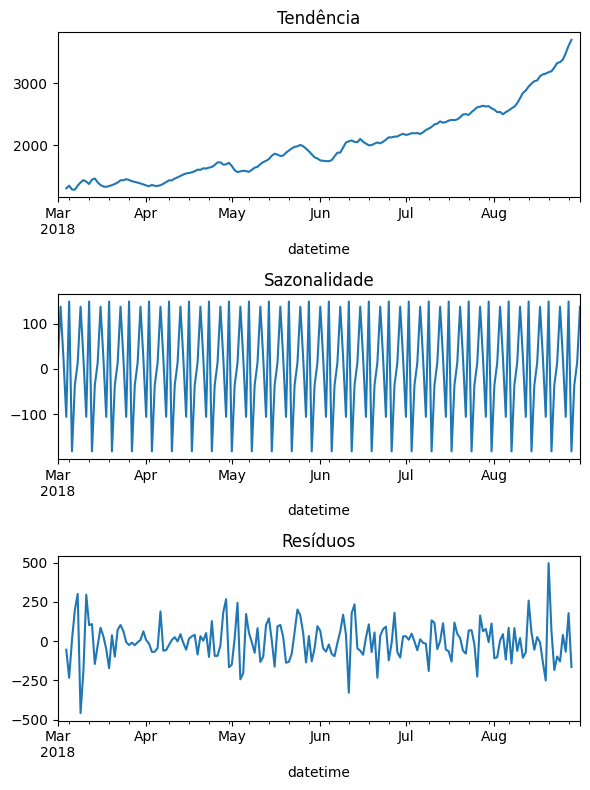

In [79]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()

Tendência: crescimento de pedidos

Sazonalidade: 2 picos a cada semana nos pedidos de taxi

Resíduo: Pode ser gerado por qualquer dia atípico, por exemplo: Feriados. Entretanto, podem também representar qualquer  evento aleatório.

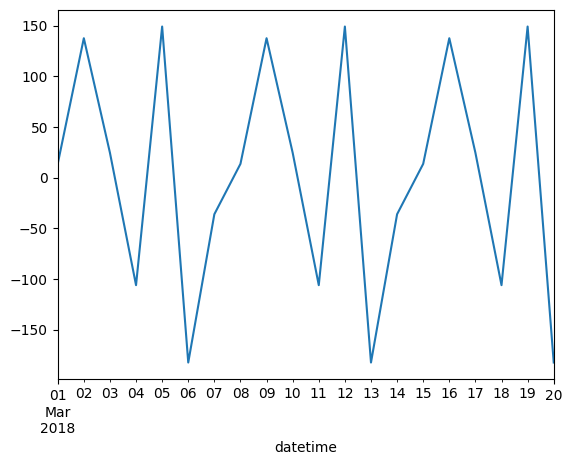

In [80]:
decomposed.seasonal['2018-03-01':'2018-03-20'].plot(); # amostra de 20 dias de março para visualizar a sazonalidade.

Percebemos 2 picos a cada semana, um mais abrupto e outro mais "suave". Um relacionado ao final de semana (sexta-feira), e outro ao começo da semana (segunda-feira).

**Observações gerais:**

Os dados tem um comportamento sazonal e tedencia de crescimento ao longo do tempo. Agora seguiremos para o treinamento do modelo.

# Treinamento 

A seguir vamos treinar os modelos de regressão linear, floresta aleatória e catboost:

In [81]:
df = df.resample('1H').sum() # preparando df de 1h em 1h
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [82]:
window = 24
# criando features
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, window, window)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [83]:
feature_train = train.drop(columns='num_orders')
feature_test = test.drop(columns='num_orders')

target_train = train['num_orders']
target_test = test['num_orders']

In [84]:
df

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


* Modelo de regressão Linear:

In [85]:
lr = LinearRegression() 
lr.fit(feature_train, target_train)

LinearRegression()

* Modelo de floresta aleatória:

In [86]:
rf = RandomForestRegressor(n_estimators=300, max_depth=7, random_state=12345)
rf.fit(feature_train, target_train)

RandomForestRegressor(max_depth=7, n_estimators=300, random_state=12345)

* Modelo CatBoost:

In [87]:
test_data = Pool(feature_train, target_train)

model = CatBoostRegressor(iterations=100,
                           depth=2,
                           learning_rate=.1,
                           verbose=False,
                           random_seed=12345
                         )

model.fit(feature_train, target_train)

# Testando

In [88]:
mean_squared_error(target_test, lr.predict(feature_test))**.5

44.991744465393225

REQM: 45, para o modelo de regressão linear

In [89]:
mean_squared_error(target_test, rf.predict(feature_test))**.5

46.03942060210135

REQM: 46, para o modelo de random forest

In [90]:
mean_squared_error(target_test, model.predict(feature_test))**.5

48.5175106428454

REQM: 48, para o catboost

# Conclusão

A análise conclusiva revela que o modelo de regressão linear se destaca como a abordagem mais eficaz para prever os pedidos de táxi para a empresa Sweet Lift Taxi, exibindo um erro quadrático médio significativamente menor (REQM: 45). Portanto, com base nos dados disponíveis neste relatório, ele se posiciona como a escolha ideal para antecipar a demanda de serviços na próxima hora, proporcionando uma oportunidade para atrair mais motoristas e otimizar as operações da empresa.